# **UAV ROUTE OPTIMIZATION USING ANT COLONY OPTIMIZATION ALGORITHM WITH TSP THEORY**
**(CASE STUDY: BUSH FIRE IN PERTH METROPOLITAN AREA)**


---

Kelompok 3:
1. Campin Waladsae Adiena (5026211050)
2. Indira Maharani (5026211090)
3. Martina Cahya Pratiwi (5026211144)

#Import Library and Dataset

###Library dan dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
import pandas as pd
from tabulate import tabulate
import folium
from folium import Marker, PolyLine

In [ ]:
# Import Dataset
df = pd.read_csv('dataset_coordinate.csv', delimiter=';')

# Filter data for clusters 2 and 10
filtered_df = df[df['CLUSTER'].isin([2, 10])][['NODE','LAT', 'LONG', 'COMBINED', 'CLUSTER']]

# Displays data for cluster 2 and 10
print("Head data for cluster 2:")
print(tabulate(filtered_df[filtered_df['CLUSTER'] == 2].head(), headers='keys', tablefmt='grid', showindex=False))

print("\nHead data for cluster 10:")
print(tabulate(filtered_df[filtered_df['CLUSTER'] == 10].head(), headers='keys', tablefmt='grid', showindex=False))

# Calculated points for each cluster
count_per_cluster = filtered_df['CLUSTER'].value_counts().reset_index()
count_per_cluster.columns = ['CLUSTER', 'JUMLAH']

print("\nTotal points for each cluster:")
print(tabulate(count_per_cluster, headers='keys', tablefmt='grid', showindex=False))

Head data for cluster 2:
+--------+---------+---------+------------------+-----------+
|   NODE |     LAT |    LONG | COMBINED         |   CLUSTER |
+========+=========+=========+==================+===========+
|      0 | -31.746 | 115.853 | -31.746,115.8526 |         2 |
+--------+---------+---------+------------------+-----------+
|      1 | -31.746 | 115.854 | -31.746,115.8537 |         2 |
+--------+---------+---------+------------------+-----------+
|      2 | -31.747 | 115.854 | -31.747,115.8539 |         2 |
+--------+---------+---------+------------------+-----------+
|      3 | -31.742 | 115.853 | -31.742,115.8529 |         2 |
+--------+---------+---------+------------------+-----------+
|      4 | -31.747 | 115.855 | -31.747,115.8548 |         2 |
+--------+---------+---------+------------------+-----------+

Head data for cluster 10:
+--------+---------+---------+------------------+-----------+
|   NODE |     LAT |    LONG | COMBINED         |   CLUSTER |
+========+========

###Dataset Visualization

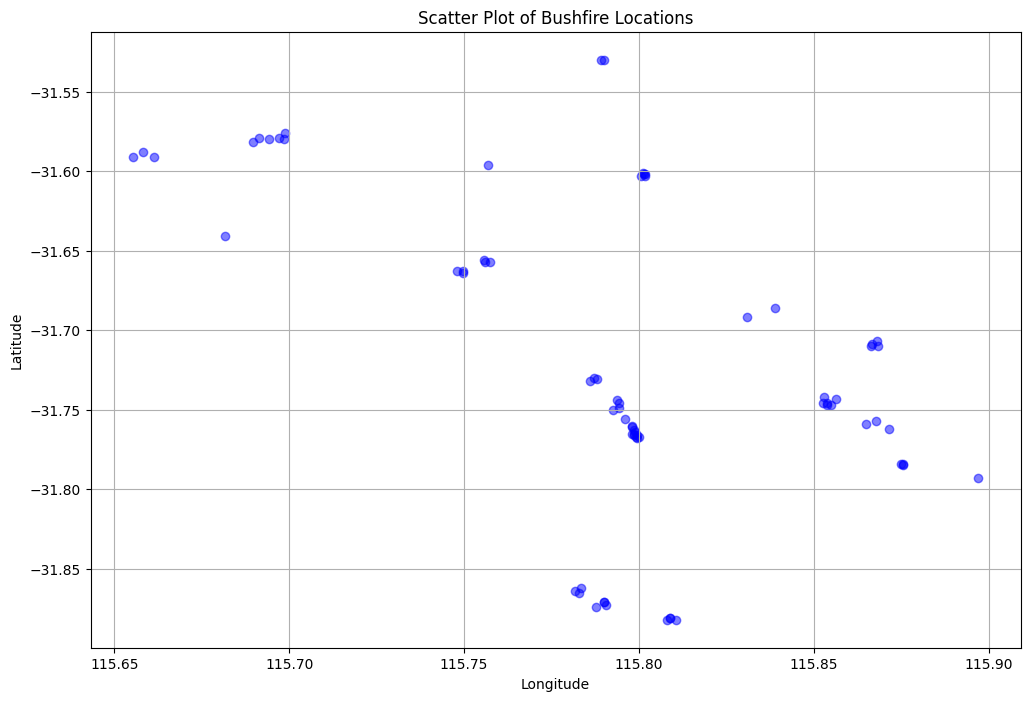

In [ ]:
# Takes the Longitude and Latitude columns
x_ = df['LONG']
y_ = df['LAT']
clusters = df['CLUSTER']

#Make Scatter Plot
plt.figure(figsize=(12, 8))
plt.scatter(x_, y_, c='blue', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Bushfire Locations')
plt.grid(True)
plt.show()

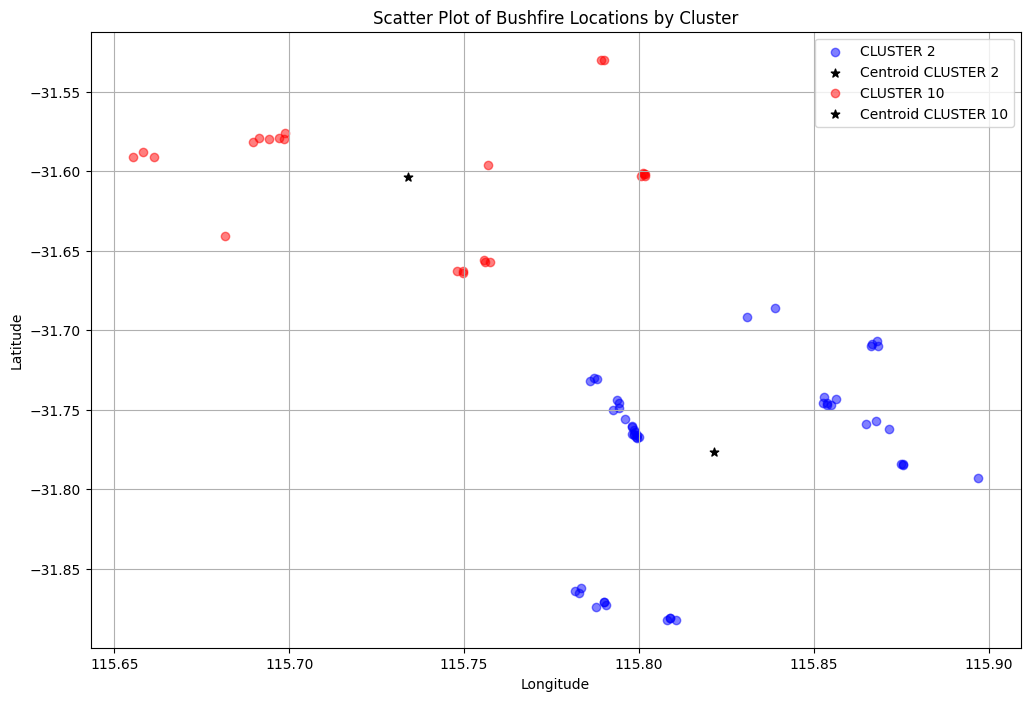

In [ ]:
# Set colors and labels for clusters 2 and 10
colors = {2: 'blue', 10: 'red'}
labels = {2: 'CLUSTER 2', 10: 'CLUSTER 10'}

# Gives centroids (Depo) for clusters 2 and 10
centroid_coords = {
    2: {'lat': -31.77683673469388, 'long': 115.82145102040818},
    10: {'lat': -31.603526, 'long': 115.733922}
}

# Create a scatter plot according to the clusters
plt.figure(figsize=(12, 8))
for cluster in colors:
    plt.scatter(x_[clusters == cluster], y_[clusters == cluster],
                c=colors[cluster], label=labels[cluster], alpha=0.5)

    # Take centroid
    centroid_x = centroid_coords[cluster]['long']
    centroid_y = centroid_coords[cluster]['lat']

    # add centroid points to plot
    plt.scatter(centroid_x, centroid_y, c='black', marker='*', s=40, label=f'Centroid {labels[cluster]}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Bushfire Locations by Cluster')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Determines the center of the map
map_center = [df['LAT'].mean(), df['LONG'].mean()]
map = folium.Map(location=map_center, zoom_start=11, tiles="openstreetmap")

# Add CircleMarker according to the cluster
colors = {2: 'blue', 10: 'red'}
for idx, cluster in enumerate(clusters):
    if cluster in colors:
        folium.CircleMarker(
            location=[y_[idx], x_[idx]],
            radius=5,
            color=colors[cluster],
            fill=True,
            fill_color=colors[cluster],
            fill_opacity=0.6,
            popup=f"Cluster {cluster}",
        ).add_to(map)

for cluster in colors.keys():
    centroid_y = centroid_coords[cluster]['lat']
    centroid_x = centroid_coords[cluster]['long']
    print(f"Centroid of Cluster {cluster}: Latitude = {centroid_y}, Longitude = {centroid_x}")

    # Added marker for centroid
    folium.Marker(
        location=[centroid_y, centroid_x],
        icon=folium.Icon(color=colors[cluster], icon='info-sign'),
        popup=f'Centroid of Cluster {cluster}',
    ).add_to(map)

# Added legend
legend_html = """
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 150px; height: auto;
                z-index: 9999; font-size: 14px;
                background-color: white;
                border:2px solid grey;
                border-radius: 5px;
                padding: 10px;">
    <h4>Legend</h4>
    <i style="background: blue; border-radius: 50%; width: 12px; height: 12px; display: inline-block;"></i> Cluster 2<br>
    <i style="background: red; border-radius: 50%; width: 12px; height: 12px; display: inline-block;"></i> Cluster 10<br>
    </div>
"""

map.get_root().html.add_child(folium.Element(legend_html))

map

Centroid of Cluster 2: Latitude = -31.77683673469388, Longitude = 115.82145102040818
Centroid of Cluster 10: Latitude = -31.603526, Longitude = 115.733922


#Ant Colony Optimization

###Initiation

In [ ]:
def ant_colony_optimization(clusters, n_ants=30, n_iterations=45, alpha=1.0, beta=8.0, evaporation_rate=0.4, q=190):
    centroids = {}
    valid_clusters = [2, 10]

    for cluster_id in valid_clusters:
        if cluster_id not in centroid_coords:
            raise KeyError(f"Centroid untuk cluster {cluster_id} tidak ditemukan.")

    for cluster_id in clusters.keys():
        centroid_y = centroid_coords[cluster_id]['lat']
        centroid_x = centroid_coords[cluster_id]['long']
        centroids[cluster_id] = Coordinate(centroid_y, centroid_x, f'Centroid {cluster_id}', cluster=cluster_id)

    best_routes = {}

    for cluster_id in valid_clusters:
       # Make sure clusters[cluster_id] is iterable
        if cluster_id not in clusters or not isinstance(clusters[cluster_id], (list, np.ndarray)):
            raise ValueError(f"Data untuk cluster {cluster_id} tidak ditemukan atau bukan iterable.")

        # Convert coordinates in clusters[cluster_id] to Coordinate objects
        coords_for_cluster = [
            centroids[cluster_id]
        ] + [
            coord if isinstance(coord, Coordinate) else Coordinate(coord['lat'], coord['long'], f'Point {i}')
            for i, coord in enumerate(clusters[cluster_id])
        ] + [
            centroids[cluster_id]
        ]

        # Combines centroid with point coordinates
        all_coords = {i: coords_for_cluster[i] for i in range(len(coords_for_cluster))}
        n_nodes = len(all_coords)

        pheromones = np.ones((n_nodes, n_nodes))
        best_cost = float('inf')
        best_route = []

        for _ in range(n_iterations):
            all_routes = []
            all_costs = []

            for _ in range(n_ants):
                route = [0]  # Start from centroid points (indeks 0)

                while len(route) < len(all_coords) - 1:
                    current_node = route[-1]
                    probabilities = []

                    for next_node in range(1, len(all_coords) - 1):  # Starting from node 1 to the last node
                        if next_node not in route:
                            pheromone = pheromones[current_node][next_node] ** alpha
                            distance = 1.0 / np.sqrt(
                                (all_coords[current_node].lat - all_coords[next_node].lat)**2 +
                                (all_coords[current_node].long - all_coords[next_node].long)**2
                            )
                            attractiveness = distance ** beta
                            probabilities.append(pheromone * attractiveness)
                        else:
                            probabilities.append(0)

                    probabilities = np.array(probabilities)

                    if probabilities.sum() > 0:
                        probabilities /= probabilities.sum()
                    else:
                        probabilities = np.ones(len(all_coords)) / len(all_coords)

                    # Select the next node based on probability
                    next_node = np.random.choice(range(1, len(all_coords) - 1), p=probabilities)
                    route.append(next_node)

                # Adds a centroid to the end of the route
                route.append(len(all_coords) - 1)

                # Calculate the total cost of the route
                total_cost, total_distance, total_rotation = Coordinate.get_total_cost([all_coords[i] for i in route])
                all_routes.append(route)
                all_costs.append(total_cost)

                # Updates the best path if a better one is found
                if total_cost < best_cost:
                    best_cost = total_cost
                    best_route = route

            # Evaporation
            pheromones *= (1 - evaporation_rate)
            for route, total_cost in zip(all_routes, all_costs):
                for i in range(len(route) - 1):
                    pheromones[route[i]][route[i + 1]] += q / total_cost
                # Deposition
                pheromones[route[-1]][route[0]] += q / total_cost
        best_routes[cluster_id] = {
            'route': [coords_for_cluster[i] for i in best_route],
            'cost': best_cost
        }

    return best_routes

In [ ]:
class Coordinate:
    def __init__(self, lat, long, id, cluster):
        self.lat = lat
        self.long = long
        self.id = id
        self.cluster = cluster

    @staticmethod
    def haversine(lat1, lon1, lat2, lon2):
        # Earth radius in kilometers
        r = 6371.0

        # Convert degrees to radians
        lat1_rad = np.radians(lat1)
        lon1_rad = np.radians(lon1)
        lat2_rad = np.radians(lat2)
        lon2_rad = np.radians(lon2)

        # Calculate the difference between latitude and longitude
        delta_lat = lat2_rad - lat1_rad
        delta_lon = lon2_rad - lon1_rad

        #Haversine Rules
        a = np.sin(delta_lat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))

        # Calculated distance
        distance = r * c
        return distance

    @staticmethod
    def get_total_cost(route):
        total_distance = sum(
            Coordinate.haversine(route[i].lat, route[i].long, route[i+1].lat, route[i+1].long)
            for i in range(len(route)-1)
        )
        total_rotation = sum(
            abs(np.arctan2(route[i+1].lat - route[i].lat, route[i+1].long - route[i].long) -
                np.arctan2(route[i].lat - route[i-1].lat, route[i].long - route[i-1].long))
            for i in range(1, len(route)-1)
        )
        total_cost = total_distance + 0.1 * total_rotation
        return total_cost, total_distance, total_rotation

###Node and Vertex Visualization

In [ ]:
def plot_coords(ax, coords, title, centroids=None, final=False):
    lats, longs = [], []

    for c in coords:
        lats.append(c.lat)
        longs.append(c.long)

    ax.plot(longs, lats, linestyle='-', color='black', linewidth=1)

    for c in coords:
        if c.cluster == 2:
            ax.scatter(c.long, c.lat, color='blue', marker='o', s=60, alpha=1.0, label='Cluster 2' if 'Cluster 2' not in ax.get_legend_handles_labels()[1] else "")
        elif c.cluster == 10:
            ax.scatter(c.long, c.lat, color='red', marker='o', s=60, alpha=1.0, label='Cluster 10' if 'Cluster 10' not in ax.get_legend_handles_labels()[1] else "")

    ax.set_title(title)
    ax.legend()

###Depo Visualization

In [ ]:
def highlight_nodes(ax, coords, cluster_id):
    if coords:
        if cluster_id == 2:
            color = 'green'
            label = 'Depo Cluster 2'
        elif cluster_id == 10:
            color = 'orange'
            label = 'Depo Cluster 10'
        else:
            return

        # Provide depots with appropriate colors and labels
        ax.plot(coords[0].long, coords[0].lat, marker='s', color=color, markersize=10, label=label, markeredgecolor='black')
        ax.legend()
    else:
        print("Koordinat kosong, tidak ada yang disorot.")

###Main Function

+------------+--------------+-------------------+---------------------+--------------------------+--------------------+
|  Cluster   | Total Points |    Total Cost     | Total Distance (km) | Total Rotation (degrees) | Total Time (hours) |
+------------+--------------+-------------------+---------------------+--------------------------+--------------------+
| Cluster 2  |      51      | 67.38178492768765 | 58.847217294417995  |    85.34567633269657     | 1.1793150591198238 |
| Cluster 10 |      26      | 56.11520937121194 |  51.42000399230905  |    46.952053789028895    | 1.0297043035625428 |
+------------+--------------+-------------------+---------------------+--------------------------+--------------------+


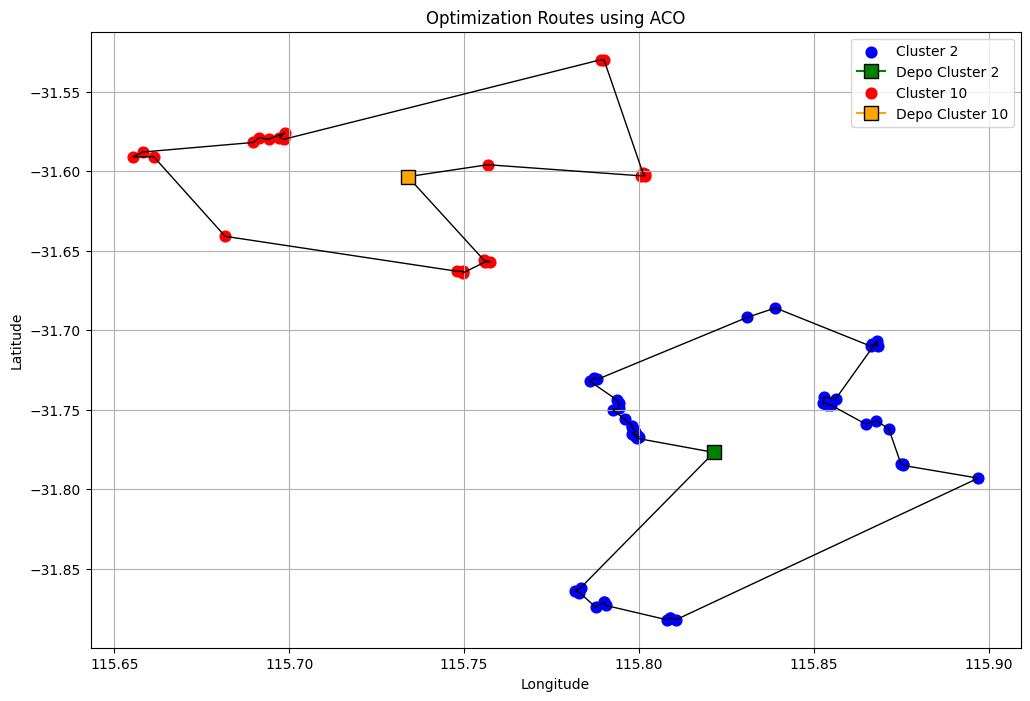

In [ ]:
# Define constants for speed and time per degree
speed = 50  # Assuming speed is 50 km/h
time_per_degree = 0.1  # Assuming each degree of rotation takes 0.1 seconds

if __name__ == '__main__':
    if 'df' not in locals() or 'centroid_coords' not in locals():
        raise ValueError("DataFrame 'df' or 'centroid_coords' is not defined.")

    clusters = {2: [], 10: []}

    # Centroid for each cluster
    centroid_2 = Coordinate(centroid_coords[2]['lat'], centroid_coords[2]['long'], 'Centroid 2', cluster=2)
    centroid_10 = Coordinate(centroid_coords[10]['lat'], centroid_coords[10]['long'], 'Centroid 10', cluster=10)

    for i, row in df.iterrows():
        if row['CLUSTER'] in [2, 10]:
            clusters[row['CLUSTER']].append(Coordinate(row['LAT'], row['LONG'], f'Point {i}', cluster=row['CLUSTER']))

    # Run the ant colony optimization
    best_routes = ant_colony_optimization(clusters)

    # Calculate the total cost, distance, rotation, and time for each route
    results = {}
    for cluster_id in [2, 10]:
        total_cost, total_distance, total_rotation = Coordinate.get_total_cost(best_routes[cluster_id]['route'])

        # Calculate time for distance and rotation
        time_distance = total_distance / speed  # Time in hours for distance
        time_rotation = total_rotation * time_per_degree / 3600  # Time in hours for rotation (converted to hours)

        total_time = time_distance + time_rotation  # Total time in hours

        results[cluster_id] = {
            'Total Cost': total_cost,
            'Total Distance (km)': total_distance,
            'Total Rotation (degrees)': total_rotation,
            'Total Points': len(best_routes[cluster_id]['route']),
            'Total Time (hours)': total_time
        }

    # Prints the results in table form, including the total time
    results_df = pd.DataFrame({
        'Cluster': [f'Cluster {cluster_id}' for cluster_id in results],
        'Total Points': [results[cluster_id]['Total Points'] for cluster_id in results],
        'Total Cost': [results[cluster_id]['Total Cost'] for cluster_id in results],
        'Total Distance (km)': [results[cluster_id]['Total Distance (km)'] for cluster_id in results],
        'Total Rotation (degrees)': [results[cluster_id]['Total Rotation (degrees)'] for cluster_id in results],
        'Total Time (hours)': [results[cluster_id]['Total Time (hours)'] for cluster_id in results]
    })

    print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

    fig, ax = plt.subplots(figsize=(12, 8))

    # Loop through each cluster and plot the route
    for cluster_id in [2, 10]:
        route = best_routes[cluster_id]['route']
        centroid = next(coord for coord in route if coord.id.startswith('Centroid'))

        plot_coords(ax, route, title=f'Rute untuk Cluster {cluster_id}', centroids=[centroid], final=True)
        highlight_nodes(ax, route, cluster_id)

    plt.title('Optimization Routes using ACO')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Function to add routes to folium maps
def add_route_to_folium(map_obj, route, node_color, centroid_color):
    folium.PolyLine([(coord.lat, coord.long) for coord in route], color=node_color, weight=5, opacity=0.7).add_to(map_obj)

    # Add markers for each point on the route
    for coord in route:
        if coord.id.startswith('Centroid'):
            folium.Marker(
                location=[coord.lat, coord.long],
                popup=coord.id,
                icon=folium.Icon(color=centroid_color)
            ).add_to(map_obj)
        else:
            folium.Marker(
                location=[coord.lat, coord.long],
                popup=coord.id,
                icon=folium.Icon(color=node_color)
            ).add_to(map_obj)

# Create maps with Folium
centroid_2_coords = (centroid_2.lat, centroid_2.long)
centroid_10_coords = (centroid_10.lat, centroid_10.long)

# Sets map focus and zoom start
map_center = [(centroid_2_coords[0] + centroid_10_coords[0]) / 2,
               (centroid_2_coords[1] + centroid_10_coords[1]) / 2]
folium_map = folium.Map(location=map_center, zoom_start=11)

# Added Route
add_route_to_folium(folium_map, best_routes[2]['route'], node_color='blue', centroid_color='green')
add_route_to_folium(folium_map, best_routes[10]['route'], node_color='red', centroid_color='orange')

folium_map